# Image I/O and manipulation

To get started, as always, we will need import the `mitsuba` and `drjit` libraries and set a variant.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Read an image from disk

Mitsuba provides a general-purpose class for reading, manipulating and writing images: [<code>Bitmap</code>][1]. This class handles loading of PNG, JPEG, BMP, TGA, as well as OpenEXR files, and it supports writing of PNG, JPEG and OpenEXR files. For PNG and OpenEXR files, it also supports storing string-valued metadata, as well as the gamma setting.

Mitsuba makes it easy to load images from disk. Here's how:

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#bitmap

In [2]:
bmp = mi.Bitmap('../scenes/textures/flower_photo.jpeg')

The string representation of the Bitmap class can be used to get more detailed information about the loaded image.

In [3]:
print(bmp)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma
    uint8 G; // @1, normalized, gamma
    uint8 B; // @2, normalized, gamma
  ],
  data = [ 6.44 MiB of image data ]
]


Let's break down those different pieces of information.

- **Pixel format**:
Specifies the pixel format (e.g. `RGBA` or `MultiChannel`) which gives both information regarding the number of channels, and how they should be interpreted.

- **Size**:
Resolution of the image.

- **Component format**:
Specifies how the per-pixel components are encoded (e.g. unsigned 8 bit integers or 32-bit floating point values). 

- **sRGB gamma correction**:
Indicates whether the gamma correction (sRGB ramp) is applied to the underlying data.

- **Internal structure**:
Describes the contents of the bitmap, its channels with names and format. For each channel, this will also show if it uses [premultiplied alpha][1].

    
By default, images loaded from PNG and JPEG flags will be assumed to be gamma corrected. This is not true for EXR images so it is important to convert them if needed with the [<code>convert()</code>][2] method.

D2fferent dedicated methods can be used to get and set various attributes, such as [<code>srgb_gamma()</code>][3] and [<code>set_srgb_gamma()</code>][4]. Although it is important to note that these methods won't affect the actual value of the stored image. This will only change how the `Bitmap` is interpreted later on.


[1]: https://en.wikipedia.org/wiki/Alpha_compositing
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.convert
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.srgb_gamma
[4]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.set_srgb_gamma


## Bitmap conversion

Once the `Bitmap` attributes are properly set, it is possible to convert the underlying data between different underlying representations. For instance, one might be interested in translating a uint8 sRGB bitmap to a linear float32 XYZ bitmap based on half-, single- or double-precision floating point-backed storage.

**Supported pixel formats**:

- `Y`: Single-channel luminance bitmap
- `YA`: Two-channel luminance + alpha bitmap
- `RGB`: RGB bitmap
- `RGBA`: RGB bitmap + alpha channel
- `RGBW`: RGB bitmap + weight (used by \ref ImageBlock)
- `RGBAW`: RGB bitmap + alpha channel + weight (used by \ref ImageBlock)
- `XYZ`: XYZ tristimulus bitmap
- `XYZA`: XYZ tristimulus + alpha channel

**Supported component formats**:
`UInt8`, `Int8`, `UInt16`, `Int16`, `UInt32`, `Int32`, `UInt64`, `Int64`, `Float16`, `Float32`, `Float64`


This can be achieved using the [<code>convert()</code>][1] method as demonstrated in the following code. All arguments for this method are optional, and if no arguments are specified, the flags of the source `Bitmap` will be used.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.convert

In [4]:
bmp = bmp.convert(
    pixel_format=mi.Bitmap.PixelFormat.RGB, 
    component_format=mi.Struct.Type.Float32, 
    srgb_gamma=True
)

bmp

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  data = [ 25.7 MiB of image data ]
]

## Metadata

The `Bitmap` class can also store string-valued metadata with the [<code>metadata()</code>][1] method. This is especially useful when working with the OpenEXR file format as metadata can be loaded and stored directly from/to the file.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.metadata

In [5]:
bmp.metadata()['test'] = 'foo'
bmp.metadata()['bar'] = 4.0

bmp

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  metadata = {
    bar => 4,
    test => "foo"
  },
  data = [ 25.7 MiB of image data ]
]

## Array interface

Thanks to its implementation of the [array interface][1], it is possible to use `Bitmap` object directly with other common Python libraries. For instance, this can be used to visualize an image in this notebook, where the `Bitmap` interacts seemslessly with `matplotlib`.

[1]: https://numpy.org/doc/stable/reference/arrays.interface.html

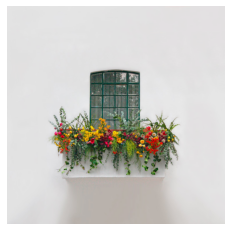

In [6]:
import matplotlib.pyplot as plt

plt.imshow(bmp); plt.axis('off');

More importantly, it is also possible to convert a `Bitmap` object into a NumPy array, or the other way around.

In [7]:
import numpy as np

# Seemless convertion Bitmap -> np.ndarray
bmp_np = np.array(bmp)
type(bmp_np), bmp_np.dtype, bmp_np.shape

(numpy.ndarray, dtype('float32'), (1500, 1500, 3))

Bitmap[
  pixel_format = y,
  component_format = float64,
  size = [100, 100],
  srgb_gamma = 0,
  struct = Struct<8>[
    float64 Y; // @0, premultiplied alpha
  ],
  data = [ 78.1 KiB of image data ]
]

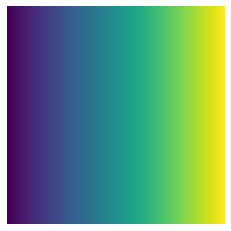

In [8]:
# It is also possible to create a Bitmap object from a numpy array
bmp_np = mi.Bitmap(np.tile(np.linspace(0, 1, 100), (100, 1)))

plt.imshow(bmp_np); plt.axis('off');

bmp_np

## Multichannel images

The `Bitmap` class is especially useful to work with multichannel image formats such as OpenEXR. Such images can easily be loaded and manipulated in Python. Here we load an OpenEXR image with many channels representing the output of our [<code>aov</code>][1] integrator, e.g. depth, shading normals, positions, ...

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

In [9]:
bmp_exr = mi.Bitmap('../scenes/textures/multi_channels.exr')

bmp_exr

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<56>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 depth.T; // @12, premultiplied alpha
    float32 image.R; // @16, premultiplied alpha
    float32 image.G; // @20, premultiplied alpha
    float32 image.B; // @24, premultiplied alpha
    float32 image.A; // @28, alpha
    float32 position.X; // @32, premultiplied alpha
    float32 position.Y; // @36, premultiplied alpha
    float32 position.Z; // @40, premultiplied alpha
    float32 sh_normal.X; // @44, premultiplied alpha
    float32 sh_normal.Y; // @48, premultiplied alpha
    float32 sh_normal.Z; // @52, premultiplied alpha
  ],
  metadata = {
    generatedBy => "Mitsuba version 3.0.0",
    pixelAspectRatio => 1,
    screenWindowWidth => 1
  },
  data = [ 3.5 MiB of image data ]
]

You can also split the `Bitmap` into multiple `Bitmap`s using the [<code>split</code>][1] method. This will return a list of pairs, with each pair containing the channel name and the corresponding `Bitmap` object.

In the following code, we plot the rendered image as well as the shading normals and depth buffer. Note that the `matplotlib` warnings are to be expected as we are working with HDR images in this example, therefore pixel values can be much higher than `1.0`.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.split

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


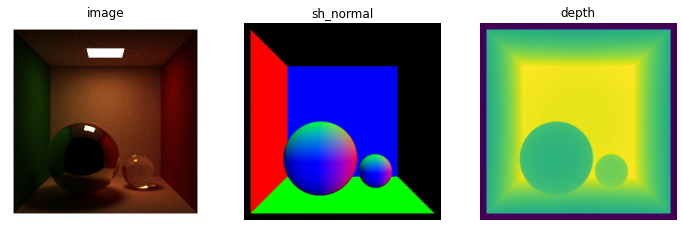

In [10]:
# Here we convert the list of pairs into a dict for easier use
res = dict(bmp_exr.split())

# Plotting the image, shading normal and depth buffer
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(res['image']);     axs[0].axis('off'); axs[0].set_title('image');
axs[1].imshow(res['sh_normal']); axs[1].axis('off'); axs[1].set_title('sh_normal');
axs[2].imshow(res['depth']);     axs[2].axis('off'); axs[2].set_title('depth');

When constructing a `Bitmap` with more than 3 channels, it is also possible to provide a list of 
channel names. The `Bitmap` class will group channels with a common suffix together when trying to split them.

In [11]:
data = np.zeros((64, 64, 5))

# .. process the data tensor ..

# Construct a bitmap object giving channel names
bmp_multi = mi.Bitmap(data, channel_names=['A.x', 'A.y', 'B.x', 'B.y', 'B.z'])

bmp_multi

Bitmap[
  pixel_format = multichannel,
  component_format = float64,
  size = [64, 64],
  srgb_gamma = 0,
  struct = Struct<40>[
    float64 A.x; // @0, premultiplied alpha
    float64 A.y; // @8, premultiplied alpha
    float64 B.x; // @16, premultiplied alpha
    float64 B.y; // @24, premultiplied alpha
    float64 B.z; // @32, premultiplied alpha
  ],
  data = [ 160 KiB of image data ]
]

## Image resampling

Resampling is a common operation in image manipulation, and it is therefore natively supported by the [<code>Bitmap</code>][1] class. For instance this could be used to upscale or downscale an image.

The [<code>resample()</code>][2] method is ideal for this purpose and is quite easy to use, as all it needs is the target image resolution.

It also takes an optional [<code>ReconstructionFilter</code>][3] object to be used during the resampling process. By default, a 2-lobe Lanczos filter will be used. Note that this `ReconstructionFilter` instance needs to come from the `scalar_rgb` variant of the system. See how the variant is explicitly specified in the code below.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.resample
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ReconstructionFilter

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  metadata = {
    bar => 4,
    test => "foo"
  },
  data = [ 48 KiB of image data ]
]

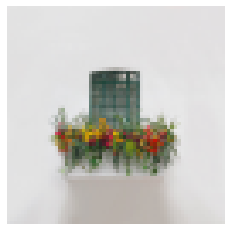

In [12]:
rfilter = mi.scalar_rgb.load_dict({'type': 'box'})

bmp_small = bmp.resample([64, 64], rfilter)

plt.imshow(bmp_small); plt.axis('off');
bmp_small

## Write image to disk

Writing images to disk is an important operation in a rendering pipeline, and here again, the [<code>Bitmap</code>][1] class has you covered. It provides both a blocking routine [<code>write()</code>][2] and asynchronous routine [<code>write_async()</code>][3] to write images to a specified path.

Note that when writing images to PNG or JPEG it is necesssary to convert the `Bitmap` object to the `uint8` component format beforehand.

Fortunately, Mitsuba also provides a helper function [<code>mi.util.write_bitmap()</code>][4] to automatically convert the Bitmap into the right format based on the output file extention before writing it to disk. As with the other routines, this process can be performed asynchronously or not using the `write_async` argument (default to `True`).

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.write
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.write_async
[4]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.util.write_bitmap

In [13]:
# Convert image to uint8
bmp_small = bmp_small.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, True)

# Write image to JPEG file
bmp_small.write('../scenes/textures/flower_photo_downscale.jpeg')

# Use the helper function to achieve the same result
mi.util.write_bitmap('../scenes/textures/flower_photo_downscale.jpeg', bmp_small, write_async=True)

## Arithmetic using `mi.TensorXf`

Unlike NumPy arrays, the [<code>Bitmap</code>][1] objects aren't meant to be manipulated with arithmetic operations. Moreover, `Bitmap` is not a differentiable type. For such operations Mitsuba provides a type [<code>TensorXf</code>][2] that behaves analogously to a NumPy array.

Thanks to the array interface protocol, a `mi.TensorXf` can be directly created from a `Bitmap` object, and vice-versa.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf

In [14]:
# Thanks to the array interface protocol, it is easy to create a TensorXf from a bitmap object
img = mi.TensorXf(bmp)

img

TensorXf(shape=(1500, 1500, 3))

After manipulating the tensorial data, it is possible to put it back into a `Bitmap` object, for instance to write it as an image on disk.

When creating a Bitmap from an array, it is assumed that the array is not gamma corrected. In our example, this is not the case, as the tensor data comes directly from a JPEG image. Therefore, it is important to set the gamma correction flag properly on the new Bitmap object.

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 25.7 MiB of image data ]
]

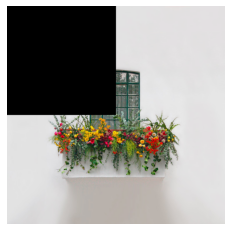

In [15]:
# Some tensorial manipulation (here we blackout the upper left corner of the image)
img[:750, :750, :] = 0.0

# Create a Bitmap from the TensorXf object
bmp_new = mi.Bitmap(img)

# Specify that the underlying data is already gamma corrected
bmp_new.set_srgb_gamma(True)

plt.imshow(bmp_new); plt.axis('off');

bmp_new